This is a quick demo of how I created [this video](https://www.youtube.com/watch?v=lZS4uaTBrh8). Check it out below, or read on to see the code that made it!

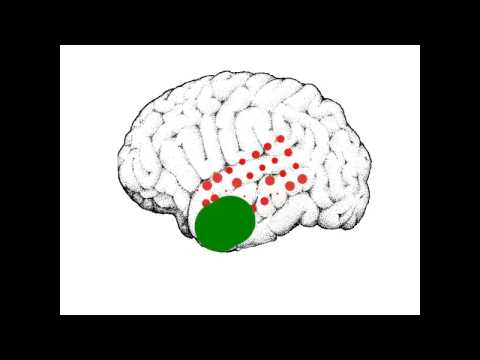

In [ ]:
from IPython.display import YouTubeVideo
YouTubeVideo('lZS4uaTBrh8')

In [ ]:
import pandas as pd
import mne
import numpy as np
import scipy.io.wavfile as wav
import matplotlib.pyplot as plt
from moviepy.editor import VideoClip, ImageClip, AudioFileClip
from moviepy.video.io.bindings import mplfig_to_npimage
from sklearn.preprocessing import MinMaxScaler
import colorbabel as cb
%matplotlib inline

# Jingle Bells!
Here's a quick viz to show off some brainy holiday spirit.

We'll use `matplotlib` and `MoviePy` to read in an audio file and generate a scatterplot that responds to the audio qualities.

In [ ]:
# Load the audio clip with MoviePy to save to the movie later
path_audio = '../../../../data/jinglebells.wav'
audio_clip = AudioFileClip(path_audio)

# Now load the sound as an array for manipulation
sfreq, audio = wav.read(path_audio)
audio = audio.T[0]

# This is the amount of time the audio takes up
time_audio = audio.shape[-1] / float(sfreq)
print('Total time: {}'.format(time_audio))

# Now read some brain info for plotting
# NOTE: this is broken, but it's an old post so I'm going to just pretend it isn't broken :-)
# melec = pd.read_csv('../../../../data/brain/meta_elec.csv')
# im = plt.imread('../../../../data/brain/brain.png')

We'll use the spectral content in the audio to drive activity in the electrodes. Here's what I'm talking about by spectral content:

[(0.0, 8000)]

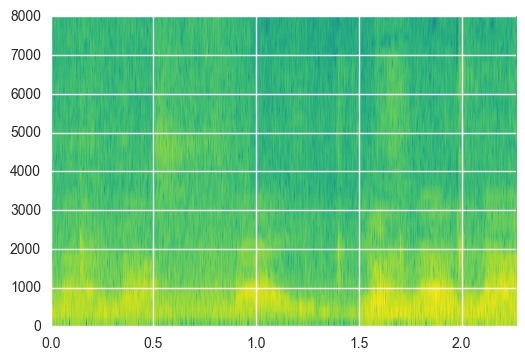

In [ ]:
# A pretty spectrogram of audio
fig, ax = plt.subplots()
_ = ax.specgram(audio[100000:200000], Fs=sfreq, cmap=plt.cm.viridis)
plt.autoscale(tight=True)
ax.set(ylim=[None, 8000])


We'll extract this information again below so we can make the viz...

In [ ]:
# Resample the audio so that it's not so long to process
sfreq_new = 11025
audio = mne.filter.resample(audio, sfreq_new, sfreq)

In [ ]:
# Now extract a spectrogram of the audio
decim = 400
sfreq_amp = sfreq_new / float(decim)
freqs = np.logspace(np.log10(400), np.log10(6000), 10)
spec = mne.time_frequency.tfr._compute_tfr(
    audio.reshape([1, 1, -1]), freqs, sfreq=sfreq_new, decim=decim)
spec = np.abs(spec).squeeze()

In [ ]:
# Low-pass filter the spectrogram so it varies more smoothly
spec = mne.filter.filter_data(spec, sfreq_amp, None, 5)

Now, we'll assign each electrode to a particular point on the y-axis of the spectrogram. We'll assign based off of the height of each electrode.

In [ ]:
# Now bin the y-point of each electrode and assign it to a specotrogram bin
y_bins = np.linspace(melec['y_2d'].min(), melec['y_2d'].max(), len(freqs))
binned_elecs = np.digitize(melec['y_2d'].values, y_bins)

# Scale the amplitude of each frequency band and assign them to electrodes
scaler = MinMaxScaler(feature_range=(0, 1.6))
amplitudes = spec[binned_elecs - 1, :]
amplitudes_scaled = np.clip(scaler.fit_transform(amplitudes.T).T, None, 1)

# Scaling etc for the scatterplot
amplitudes_sizes = np.clip(amplitudes_scaled, .01, None) * 100
amplitudes_sizes **= 2
amplitudes_sizes *= 1  # Set to 1 to not change size at all

In [ ]:
# Set the sampling frequency for the video so it fills up all the audio time
n_frames = amplitudes.shape[-1]
duration = time_audio
sfreq_video = n_frames / duration
print(sfreq_video)

27.5642161205%2525250A

# Making the movie

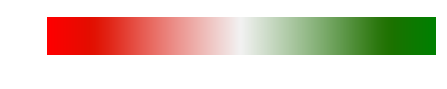

In [ ]:
# Here is our colorbar
trans = cb.ColorTranslator(['red', 'green'])
cmap = trans.to_diverging(mid_spread=.8)
cb.ColorTranslator(cmap).show_colors()

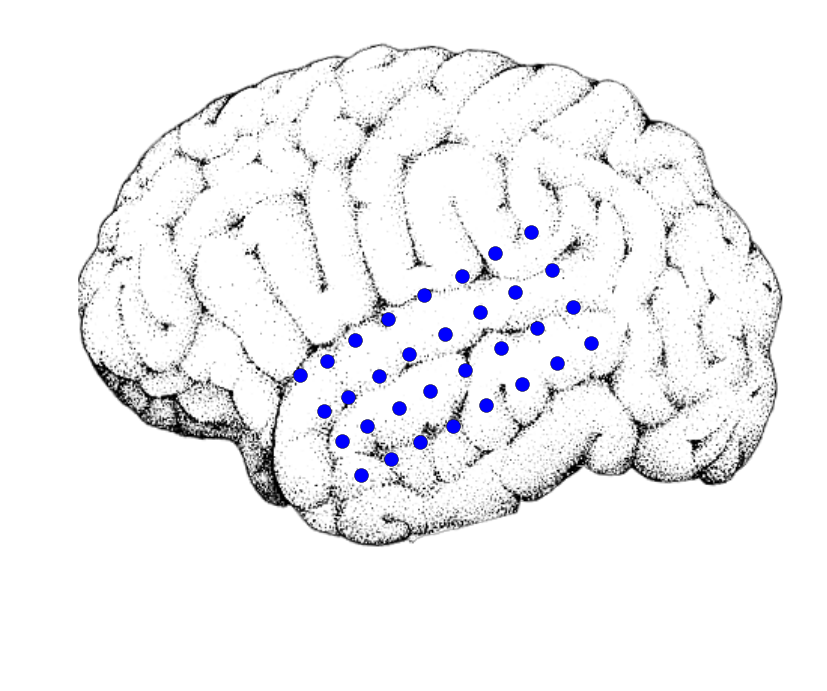

In [ ]:
# Here's an example of what the plot looks like
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(im)
ax.set_axis_off()
scat = ax.scatter(*melec[['x_2d', 'y_2d']].values.T, s=100)

In [ ]:
# This function maps a time (in seconds) onto an index
# It sets the scatterplot sizes from that index
# Then it returns the image of the figure.
def animate_scatterplot(t):
    ix = int(np.round(t * sfreq_video)) - 1
    sizes = amplitudes_sizes[:, ix]
    colors = amplitudes_scaled[:, ix]
    scat.set_sizes(sizes)
    scat.set_color(cmap(colors))
    return mplfig_to_npimage(fig)

# Now we'll create our videoclip using this function, and give it audio
clip = VideoClip(animate_scatterplot, duration=duration)
clip.audio = audio_clip

# Finally, write it to disk
clip.write_videofile('../data/jinglebells.mp4', fps=sfreq_video, audio=True)

%2525255BMoviePy%2525255D%25252520%25252526gt%25252526gt%25252526gt%25252526gt%25252520Building%25252520video%25252520../data/jinglebells.mp4%2525250A%2525255BMoviePy%2525255D%25252520Writing%25252520audio%25252520in%25252520jinglebellsTEMP_MPY_wvf_snd.mp3%2525250A%2525255BMoviePy%2525255D%25252520Done.%2525250A%2525255BMoviePy%2525255D%25252520Writing%25252520video%25252520../data/jinglebells.mp4%2525250A%2525255BMoviePy%2525255D%25252520Done.%2525250A%2525255BMoviePy%2525255D%25252520%25252526gt%25252526gt%25252526gt%25252526gt%25252520Video%25252520ready%2525253A%25252520../data/jinglebells.mp4%25252520%2525250A%2525250A

And now you've got a great video!

*Credit for the nice brain image goes to the excellent [Benedicte Rossi](http://benedicterossi.com/)*